In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import classification_report
from time import time

In [2]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50
from torch import nn
import torch

In [3]:
model = resnet50(pretrained=True)

class Identity(nn.Module):
    def forward(self, inputs):
        return inputs

model.fc = Identity()

In [18]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

dataset = ImageFolder(
    '/mnt/qb/datasets/ImageNet-C/speckle_noise/5',
    transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         normalize,
    ])
)
    
train_count = int(0.7 * len(dataset))
val_count = int(0.3 * len(dataset))
train_dataset, val_dataset = random_split(
    dataset, (train_count, val_count)
)
    
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=100)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=100)

In [19]:
model.eval()
def convert_to_latent(loader, max_length=80000):
    xo, xl, yl = [], [], []
    for x, y in loader:
        res = model(x).cpu()
        x, y = x.cpu(), y.cpu()
#         res = get_latent(x, inference_model)
#         res = res.reshape((res.shape[0], res.shape[1] * res.shape[2] * res.shape[3]))
        xo.extend(x.detach().numpy())
        xl.extend(res.detach().numpy())

        yt = y.detach().numpy()
        yt[yt <= 500] = +1
        yt[yt > 500] = -1
        yl.extend(yt)
        if len(yl) >= max_length:
            break
    print(f"Converted {len(xo)} datapoints to latent space.")
    return np.array(xo), np.array(xl), np.array(yl)

s = time()
train_latent = convert_to_latent(train_loader, 1000)
print('Elapsed:', time() - s, 's')

Converted 1000 datapoints to latent space.
Elapsed: 177.1337718963623 s


In [20]:
val_latent = convert_to_latent(val_loader, 500)

Converted 500 datapoints to latent space.


In [21]:
print("Train latent:",
      sum([train_latent[i].size * train_latent[i].itemsize for i in range(len(train_latent))])/1024**2, 'MB')
print("Val latent:",
      sum([val_latent[i].size * val_latent[i].itemsize for i in range(len(val_latent))])/1024**2, 'MB')

Train latent: 582.0388793945312 MB
Val latent: 291.0194396972656 MB


In [22]:
train_latent[2]

array([-1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
       -1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,
        1, -1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,
        1, -1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,
        1, -1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,
       -1,  1,  1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1,
        1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1,  1,
       -1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1, -1, -1,
        1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1,
       -1, -1,  1, -1,  1

In [23]:
ksvm = SVC(kernel='rbf')
ksvm.fit(train_latent[1], train_latent[2])

true_y, pred_y = val_latent[2], ksvm.predict(val_latent[1])
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

          -1      0.704     0.828     0.761       238
           1      0.814     0.683     0.743       262

    accuracy                          0.752       500
   macro avg      0.759     0.755     0.752       500
weighted avg      0.761     0.752     0.751       500



In [29]:
def convert_to_imshow(image):
    return np.swapaxes(np.swapaxes(image, 0, 2), 0, 1)

# def convert_to_imshow(tensor):
#     std = torch.tensor(normalize.std).view(3, 1, 1)
#     mean = torch.tensor(normalize.std).view(3, 1, 1)
#     return TF.to_pil_image(torch.clamp(tensor * std + mean, 0, 1))

[1]


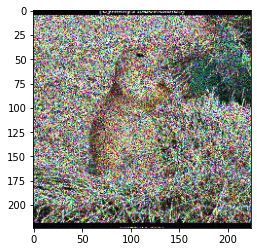

In [30]:
orig_i = np.argmax(val_latent[2])
print(ksvm.predict(val_latent[1][orig_i:orig_i+1, :]))
plt.imshow(convert_to_imshow(val_latent[0][orig_i]))

In [26]:
km = rbf_kernel(ksvm.support_vectors_, val_latent[1][orig_i:orig_i+1, :])
km *= train_latent[2][ksvm.support_].reshape(len(ksvm.support_), 1)

def ksvm_label_flip(inds):
    prev = ksvm.predict(val_latent[1][orig_i:orig_i+1, :])[0]
    # Create coefficient backup
    backup = np.copy(ksvm._dual_coef_)
    # Flip labels
    ksvm._dual_coef_[0, inds] = -ksvm._dual_coef_[0, inds]
    # Check prediction
    after = ksvm.predict(val_latent[1][orig_i:orig_i+1, :])[0]
    # Restore coefficients
    ksvm._dual_coef_ = backup
    return prev, after

# Find the tipping point
label_flip_len = -1
inds = np.flip(km.argsort(axis=0).flatten())
beyond_end = 5
for i in range(1, len(inds)+1):
    p, a = ksvm_label_flip(inds[:i])
    if p != a:
        print("Label flips:", i)
        label_flip_len = i
        inds = inds[:label_flip_len + beyond_end]
        break

Label flips: 1


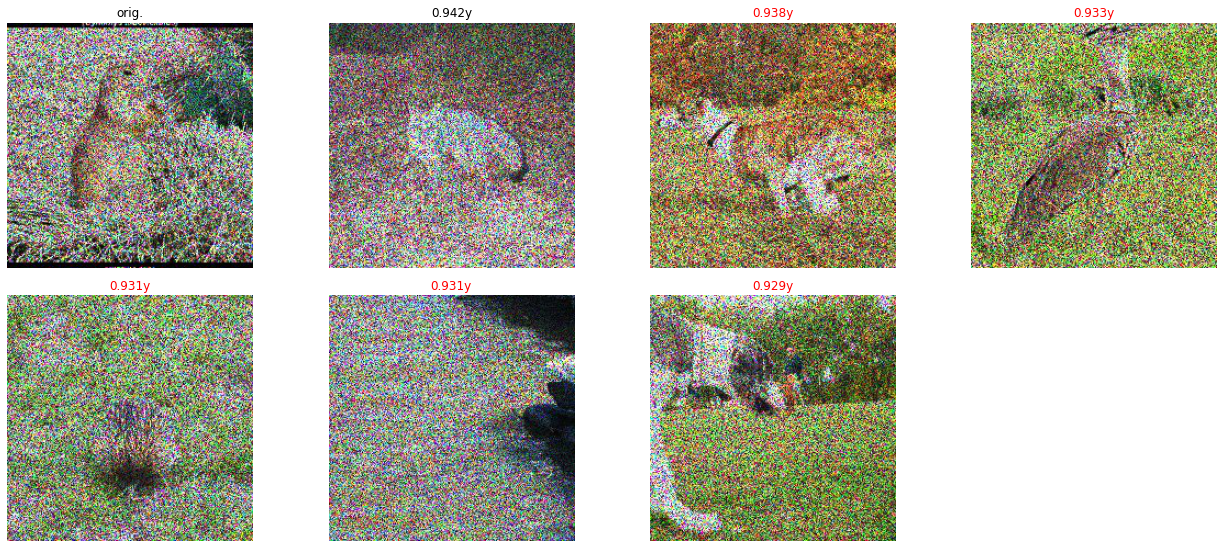

In [38]:
plt.figure(figsize=(18, 10))
plt.subplot(10, 4, 1); plt.title('orig.'); plt.axis('off')
plt.imshow(convert_to_imshow(val_latent[0][orig_i]))
for i, ind in enumerate(inds):
    ti = ksvm.support_[ind]
    plt.subplot(10,4,i+2)
    plt.axis('off')
    plt.title(
        "{:.3f}{}".format(km[ind][0], 'y' if train_latent[2][ti] == 1 else 'n'), 
        fontdict={ 'color': 'red' if i >= label_flip_len else 'black' })
    plt.imshow(convert_to_imshow(train_latent[0][ti]))
plt.tight_layout()
plt.show()

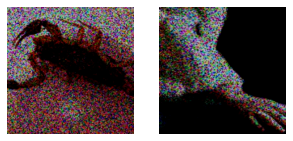

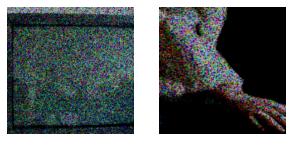

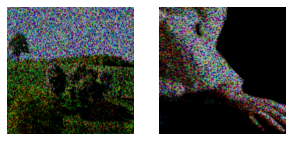

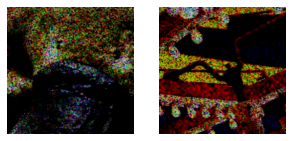

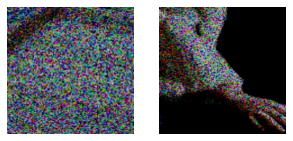

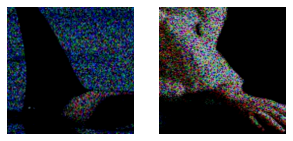

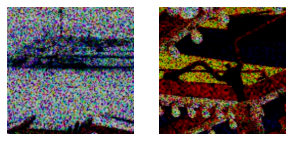

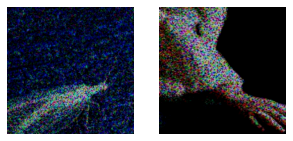

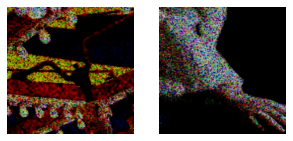

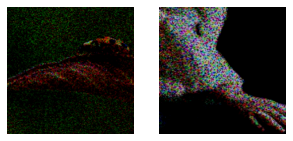

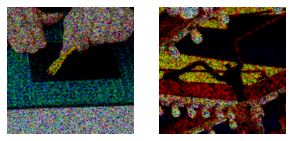

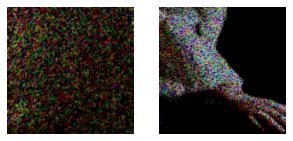

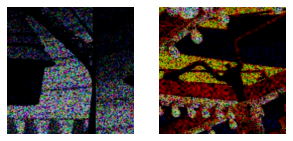

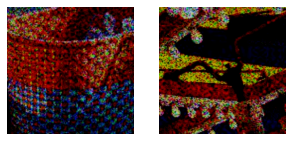

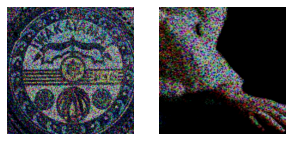

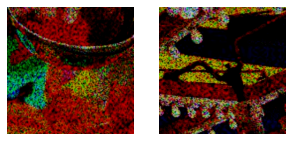

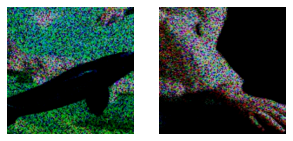

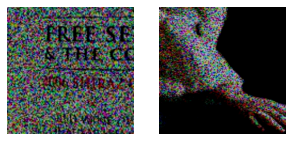

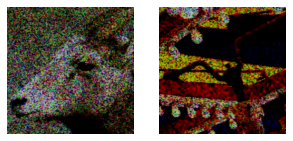

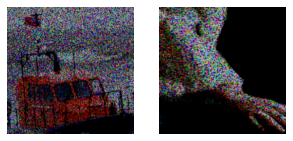

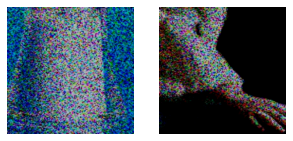

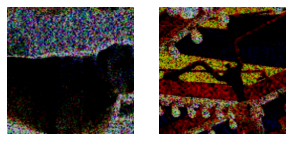

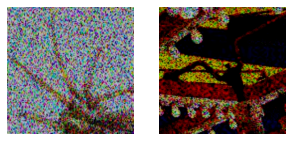

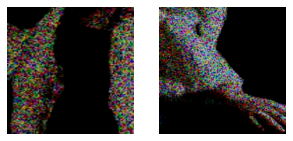

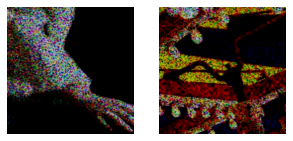

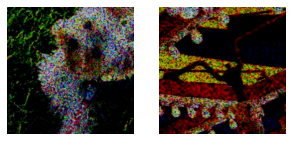

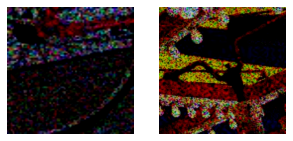

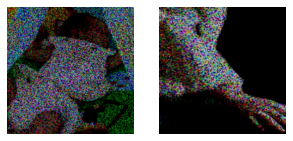

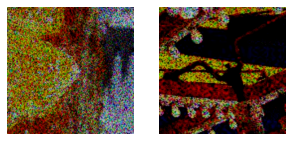

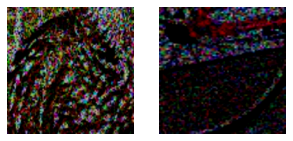

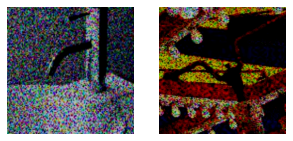

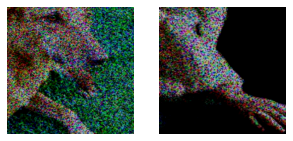

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def to_image(tensor):
    std = torch.tensor(normalize.std).view(3, 1, 1)
    mean = torch.tensor(normalize.std).view(3, 1, 1)
    return TF.to_pil_image(torch.clamp(tensor * std + mean, 0, 1))

distances = (features @ features.T)
distances[torch.eye(len(distances), dtype=torch.long) > 0] = 0.

nns = distances.argmax(axis = -1)

for i, image in enumerate(images):

    fig, axes = plt.subplots(1,2,figsize=(5, 4))
    axes[0].imshow(to_image(image))
    axes[1].imshow(to_image(images[nns[i]]))
    for ax in axes: ax.axis("off")
    plt.show()
    plt.close()